<div align="center">
    <h1> Optimization - Gradients </h1>
</div>

In this notebook, we will present the concept of gradients and how they are used in optimization algorithms.

# Table of Contents
1. [Important misc](#important-misc)
2. [Gradient Descent](#gradient-descent)
3. [Steepest Descent](#steepest-descent)
4. [Conjugate Directions](#conjugate-directions)
5. [Conjugate Gradient](#conjugate-gradient)

## Important misc <a name="important-misc"></a>

The main criterias to stop the optimization algorithms are:
- $||\nabla f(x)|| < \epsilon$
- $||x_{k+1} - x_k|| < \epsilon$
- $|f(x_{k+1}) - f(x_k)| < \epsilon$

In [2]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_func(func, x, y, x_start, x_min, trajectory, type=1):
    '''
    Function to plot the contour and the optimization trajectory

    Parameters:
    func - function to optimize
    x_start - starting point
    x_min - minimum point
    trajectory - optimization trajectory
    type - type of contour -> 1 for cmap='viridis' and 2 for 'royalblue square style'
    '''
    plt.close('all')
    arx = plt.figure().add_subplot(projection='3d')
    X, Y = np.meshgrid(x, y)

    if type == 2:
        arx.plot_surface(X, Y, func([X, Y]), edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)
    else:
        arx.contour3D(X, Y, func([X, Y]), 60, cmap='viridis')

    arx.set_xlabel('x')
    arx.set_ylabel('y')
    arx.set_zlabel('f(x, y)')

    
    arx.scatter(x_start[0], x_start[1], func(x_start), color='red')
    arx.scatter(x_min[0], x_min[1], func(x_min), color='black')
    arx.plot(trajectory[:, 0], trajectory[:, 1], func(trajectory.T), color='red')
    plt.show()

In [10]:
#Choose the function which you want to plot

def func(x):
    # Function 1
    # return x[0]**2 + x[1]**2

    # Function 2
    #return np.cos(x[1]) * np.sin(x[0])**2 + 1 / (x[0]**2 + x[1]**2 + 1) - np.cos(x[0])

    # Function 3
    return 0.5*(x[0] - 4.5)**2 + 2.5*(x[1] - 2.3)**2

def func_grad(x):
    #Function 1
    # return np.array([2*x[0], 2*x[1]])

    #Function 2
    #x_grad = -np.sin(x[0]) * np.sin(x[1]) + 2*x[0] / (x[0]**2 + x[1]**2 + 1)**2 + np.sin(x[0])
    #y_grad = np.cos(x[0]) * np.cos(x[1]) + 2*x[1] / (x[0]**2 + x[1]**2 + 1)**2 - np.cos(x[1])
    #return np.array([x_grad, y_grad])

    #Function 3
    return np.array([x[0] - 4.5, 5*(x[1] - 2.3)])

## The method of Gradient Descent <a name="gradient-descent"></a>

The gradient descent method is an optimization algorithm that in most of the cases is used to find the global minimum of a function. The function used is:

<div align="center">

$x^{(k+1)} = x^{(k)} - \alpha \nabla f(x^{(k)})$

</div>

The parameters are:
* `x_start`: the initial point
* `alpha`: the learning rate
* `epsilon`: the stopping criteria
* `func_gradient`: the gradient of the function
* `breakpoint` (optional): choose which stopping criteria to use

Minimum point: [2.55872592e-05 2.55872592e-05]
Number of steps: 24


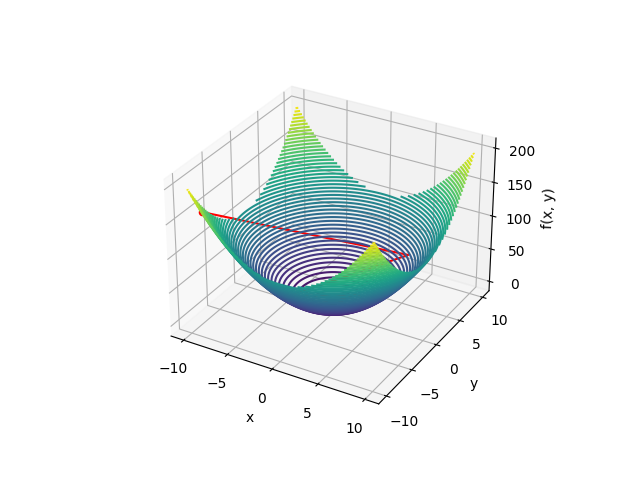

In [40]:
def descent(x, func_gradient, alpha, epsilon, breakpoint='derivative'):
    x_new = np.zeros(x.shape)
    trajectory = np.array([x])
    i = 0

    while True:

        x_new = x - alpha * func_gradient(x)

        if breakpoint == 'gradient':
            if abs(func(x_new)) < epsilon:
                break
        elif breakpoint == 'function':
            if abs(func(x) - func(x_new)) < epsilon:
                break
        elif breakpoint == 'steps':
            if np.linalg.norm(x - x_new) < epsilon:
                break

        # Uncomment to see the steps
        # print('Step:', i, 'x:', x, 'f(x):', func(x))
        
        i += 1
        x = x_new
        trajectory = np.append(trajectory, [x])
    
    return x_new, trajectory.reshape(-1, 2), i

# Starting variables
x_start = np.array([-9, -9])
alpha = 0.8
epsilon = 0.0001
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

# Calling the function
x_min, trajectory, steps = descent(x_start, func_grad, alpha, epsilon, breakpoint='steps')

print('Minimum point:', x_min)
print('Number of steps:', steps)

# Plot the function
plot_func(func, x, y, x_start, x_min, trajectory, type=1)

## The method of Steepest Descent

We consider $x^{(0)}$ to be the initial point. Then the formula for the steepest descent is:

<div align="center">

$x^{(k+1)} = x^{(k)} - \alpha_k \nabla f(x^{(k)})$

</div>

where

<div align="center">

$\alpha_k = \arg \min_{\alpha \geq 0} f(x^{(k)} - \alpha \nabla f(x^{(k)})$

</div>

As $\alpha_k$ requires a line search which is computationally expensive, we can use :
<div align="center">

$f(x_k + \alpha_k p_k) \leq f(x_k) - c_1 * \alpha_k \nabla f(x_k)^T p_k$ &nbsp; &nbsp; <b>(SDC)</b>  <br>
$\nabla f(x_k + \alpha_k p_k)^T p_k \geq c_2 \nabla f(x_k)^T p_k$  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; <b>(CC)</b>

</div>

with $0 < c_1 < c_2 < 1$.

This conditions are called Wolfe Conditions for Line Search. The first condition is called Armijo Rule (or sufficient decrease condition(SDC)) and the second condition is called curvature condition(CC).


Minimum point: [0. 0.]
Number of steps: 1
Alpha values: [1.  0.5 0.5]


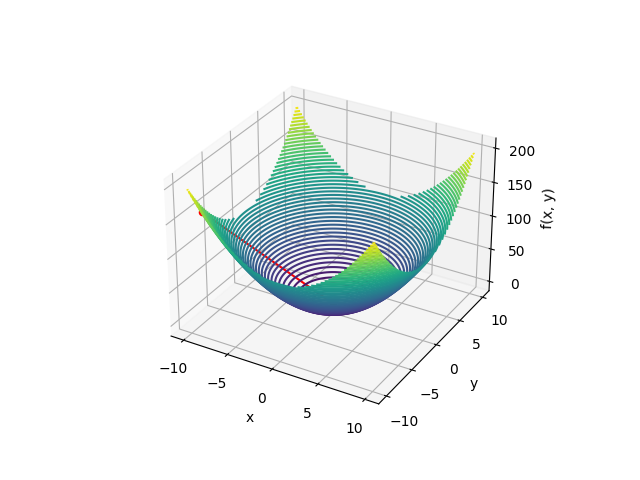

In [36]:
def sufficient_decrease_rule(x_k, alpha, func, func_gradient, c=10**-4, epsilon=10**-6):
    '''
    Backtracking line search using the SDC

    Parameters:
    x_k - current point
    alpha - step size
    func - function to optimize
    func_gradient - gradient of the function
    c - constant (default 10^-4)
    p - constant (default 0.5)
    epsilon - tolerance (default 10^-6)

    Returns:
    aplha - the new step size  
    
    '''
    while func(x_k - alpha * func_gradient(x_k)) > func(x_k) - c * alpha * func_gradient(x_k).T @ func_gradient(x_k):
        alpha /= 2
    
        if alpha < epsilon:
            break

    return alpha

def steepest_descent(x, func_gradient, epsilon, max_iter=10000, breakpoint='derivative'):
    x_new = np.zeros(x.shape)
    trajectory = np.array([x])
    alpha = 1.0
    alpha_values = np.array([alpha])
    i = 0

    while i < max_iter:

        # Calculate the alpha using the Armijo rule
        alpha = sufficient_decrease_rule(x, alpha, func, func_gradient)
        x_new = x - alpha * func_gradient(x)

        # Store the values
        alpha_values = np.append(alpha_values, alpha)
        trajectory = np.append(trajectory, [x], axis=0)

        if breakpoint == 'gradient':
            if abs(func(x_new)) < epsilon:
                break
        elif breakpoint == 'function':
            if abs(func(x) - func(x_new)) < epsilon:
                break
        elif breakpoint == 'steps':
            if np.linalg.norm(x - x_new) < epsilon:
                break

        # Uncomment to see the steps
        # print('Step:', i, 'x:', x, 'f(x):', func(x))
        
        i += 1
        x = x_new     
    
    return x_new, trajectory.reshape(-1, 2), i, alpha_values


'''Starting variables'''
x_start = np.array([-9, -9])
epsilon = 0.0001
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

# Calling the function
x_min, trajectory, steps, alpha_values = steepest_descent(x_start, func_grad, epsilon, breakpoint='steps')

print('Minimum point:', x_min)
print('Number of steps:', steps)

# Limit the values of alpha to print
if alpha_values.size > 10:
    print('Alpha values:', alpha_values[:3], '...', alpha_values[-3:])
else:
    print('Alpha values:', alpha_values)

# Plot the function
plot_func(func, x, y, x_start, x_min, trajectory, type=1)

## Conjugate Direction Method

We consider $x^{(0)}$ to be the initial point and $d^{(0)},d^{(1)},...,d^{(n-1)}, n$ directions Q-conjugated. For $k = 0,1,...,$ we have:

<div align="center">

$g^{(k)} = \nabla f(x^{(k)}) = Qx^{(k)} - b$ <br><br>
$\alpha_k = - \frac{(g^{(k)})^Td^{(k)}}{(d^{(k)})^TQd^{(k)}}$ <br><br>
$x^{(k+1)} = x^{(k)} + \alpha_k d^{(k)}$
</div>

Alpha: -0.25
Alpha: 2.0
Minimum point: [-1.   1.5]
Number of steps: 2
Trajectory: [[ 0.    0.  ]
 [-0.25  0.  ]
 [-1.    1.5 ]]


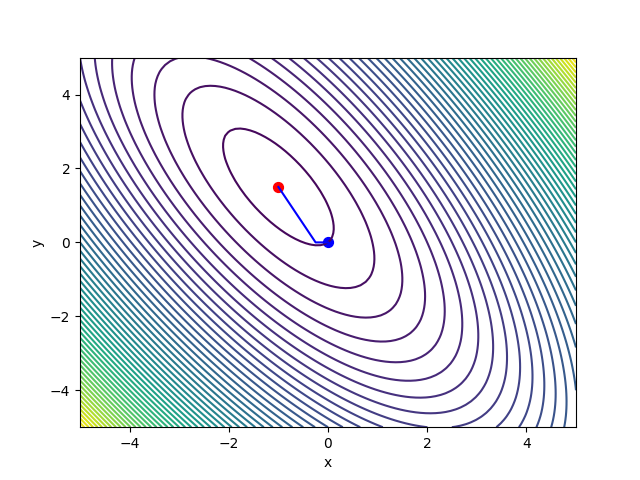

In [47]:
def conjugate_direction(x, Q, beta, epsilon, direction, max_iter=100):
    x_new = np.zeros(x.shape)
    trajectory = np.array([x])
    i = 0

    while i < max_iter:
        p = Q @ x - beta
        alpha = - (p.T @ direction[i]) / (direction[i].T @ Q @ direction[i])

        print('Alpha:', alpha)

        x_new = x + alpha * direction[i]

        if np.linalg.norm(x - x_new) < epsilon:
            break

        i += 1
        x = x_new
        trajectory = np.append(trajectory, [x], axis=0)

    return x_new, trajectory.reshape(-1, 2), i

'''Starting variables'''
x_start = np.array([0, 0])
epsilon = 0.0001
Q = np.array([[4, 2], [2, 2]])
b = np.array([-1, 1])
dir = np.array([[1, 0], [-3/8, 3/4]])
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)

def func_matrix_from(x, Q=Q, beta=b):
    return 0.5 * x.T @ Q @ x - x.T @ beta

def func_grad_matrix_form(x, Q=Q, beta=b):
    return Q @ x - beta

# Calling the function
x_min, trajectory, steps = conjugate_direction(x_start, Q, b, epsilon, dir, max_iter=2)

print('Minimum point:', x_min)
print('Number of steps:', steps)
print('Trajectory:', trajectory)

# Plot the function
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = func_matrix_from(np.array([X[i, j], Y[i, j]]))

plt.close('all')
plt.contour(X, Y, Z, 60, cmap='viridis')
plt.scatter(x_start[0], x_start[1], color='blue', s=50)
plt.scatter(x_min[0], x_min[1], color='red', s=50)
plt.plot(trajectory[:, 0], trajectory[:, 1], color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Conjugate Gradient Method

We consider $x^{(0)}$ to be the initial point.

We choose:
<div align="center">

$d^{(0)} = \nabla f(x^{(0)}) = -g^{(0)}$

</div>

At k-th step, we have:
<div align="center">

$g^{(k)} = \nabla f(x^{(k)})$ <br><br>
$d^{(k)} = -g^{(k)} + \beta_{k-1} d^{(k-1)}$ <br><br>
$\beta_{k-1} = \frac{(g^{(k)})^TQd^{(k-1)}}{(d^{(k-1)})^TQd^{(k-1)}}$ <br><br>
$\alpha_k = - \frac{(g^{(k)})^Td^{(k)}}{(d^{(k)})^TQd^{(k)}}$

</div>

Each step becomes:
<div align="center">

$x^{(k+1)} = x^{(k)} + \alpha_k d^{(k)}$

</div>

Alpha: 0.20903149874562518
Alpha: 0.9567935990517114
Minimum point: [4.5 2.3]
Number of steps: 2
Trajectory: [[-9.         -9.        ]
 [-6.17807477  2.81027968]
 [ 4.5         2.3       ]]


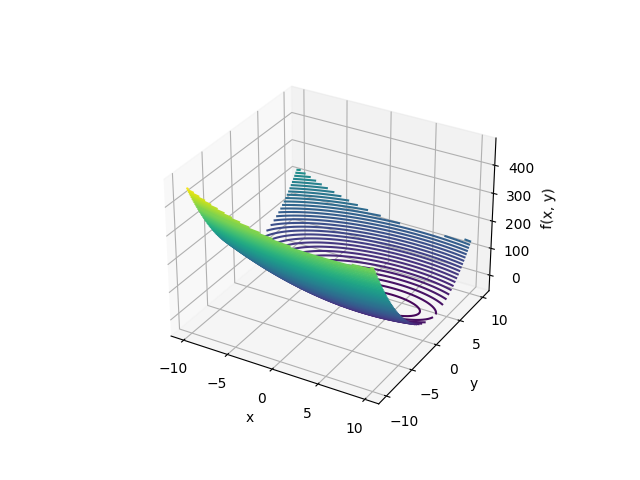

In [48]:
def conjugate_gradient(x, Q, b, epsilon, max_iter=100):
    x_new = np.zeros(x.shape)
    trajectory = np.array([x])
    i = 0

    while i < max_iter:
        p = Q @ x - b

        if i == 0:
            d = -p
        else:
            beta = (p.T @ Q @ d) / (d.T @ Q @ d)
            d = -p + beta * d

        # If the denominator is too small, break the loop
        denominator = d.T @ Q @ d
        if np.abs(denominator) < 10**-10:
            break

        alpha = (-1) * (p.T @ d) / denominator

        print('Alpha:', alpha)

        x_new = x + alpha * d

        if np.linalg.norm(x - x_new) < epsilon:
            break

        i += 1
        x = x_new
        trajectory = np.append(trajectory, [x], axis=0)

    return x_new, trajectory.reshape(-1, 2), i

'''Starting variables'''
x_start = np.array([-9, -9])
epsilon = 0.0001
Q = np.array([[1, 0], [0, 5]])
b = np.array([4.5, 11.5])
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

def func_matrix_from(x, Q=Q, b=b):
    return 0.5 * x.T @ Q @ x - b.T @ x

def func_grad_matrix_form(x, Q=Q, b=b):
    return Q @ x - b

# Calling the function
x_min, trajectory, steps = conjugate_gradient(x_start, Q, b, epsilon, max_iter=5)

print('Minimum point:', x_min)
print('Number of steps:', steps)
print('Trajectory:', trajectory)

# Plot the function
arx = plt.figure().add_subplot(projection='3d')
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = func_matrix_from(np.array([X[i, j], Y[i, j]]))

arx.contour3D(X, Y, Z, 60, cmap='viridis')

arx.set_xlabel('x')
arx.set_ylabel('y')
arx.set_zlabel('f(x, y)')

# Check if the minimum point is nan
if np.isnan(x_min).any():
    x_min = trajectory[-1]
    
arx.scatter(x_start[0], x_start[1], func_matrix_from(x_start), color='red')
arx.scatter(x_min[0], x_min[1], func_matrix_from(x_min), color='black')

z_trajectory = [func_matrix_from(x) for x in trajectory]
arx.plot(trajectory[:, 0], trajectory[:, 1], z_trajectory, color='red')

plt.show()

## Stochastic Gradient Descent (TODO)

* Square loss (loss function used in linear regression)

$l_{squared}(x,y,h) = (y - h(x))^2$

* Cross-entropy loss (loss function used in classification)

$l(x,y,h) = -y \log(h(x)) - (1 - y) \log(1 - h(x))$

* Hinge loss (loss function used in classification) (used in SVM)

$l(x,y,h) = \max(0, 1 - yh(x))$

* absolute loss (loss function used in regression)

$l_{abs}(x,y,h) = |y - h(x)|$

* Huber loss (loss function used in regression)

$l_{huber}(x,y,h) = \begin{cases} \frac{1}{2}(y - h(x))^2 & \text{if } |y - h(x)| \leq \delta \\ \delta |y - h(x)| - \frac{1}{2} \delta^2 & \text{otherwise} \end{cases}$

> you can tune the hyperparameter $\delta$ to control the smoothness of the loss function

* log-cosh loss (loss function used in regression)

$l_{logcosh}(x,y,h) = \log(\cosh(y - h(x)))$

* Quantile loss (loss function used in quantile regression)

$l_{\tau}(x,y,h) = \begin{cases} \tau(y - h(x)) & \text{if } y - h(x) \geq 0 \\ (\tau - 1)(y - h(x)) & \text{otherwise} \end{cases}$

In [5]:
# LOSS Functions for stochastic gradient descent

# Loss functions for regression
def square_loss(y, y_pred):
    return (y - y_pred)**2

def absolute_loss(y, y_pred):
    return np.abs(y - y_pred)

def huber_loss(y, y_pred, delta=1):
    if np.abs(y - y_pred) <= delta:
        return 0.5 * (y - y_pred)**2
    else:
        return delta * np.abs(y - y_pred) - 0.5 * delta**2
    
def log_cosh_loss(y, y_pred):
    return np.log(np.cosh(y - y_pred))

def quantile_loss(y, y_pred, q=0.5):
    if y - y_pred >= 0:
        return q * (y - y_pred)
    else:
        return (q - 1) * (y - y_pred)

# Loss functions for classification
def cross_entropy_loss(y, y_pred):
    return -y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred)

def hinge_loss(y, y_pred):
    return np.maximum(0, 1 - y * y_pred)

In [ ]:
# TODO
def gradient_square_loss(y, y_pred, x):
    return -2 * (y - y_pred)

def stochastic_gradient_descent(x, y, alpha,  batch_size, epsilon, loss_func, gradient_loss_func, model_type='regression', max_iter=100):
    x_new = np.zeros(x.shape[1])
    trajectory = np.array([x_new])
    i = 0

    while i < max_iter:
        # Randomly select the batch
        idx = np.random.choice(len(y), batch_size, replace=False)
        x_batch = x[idx]
        y_batch = y[idx]

        if model_type == 'regression':
            y_pred = x_batch @ x_new
        elif model_type == 'classification':
            y_pred = 1 # TODO

        gradient = 1 / batch_size * np.sum(gradient_loss_func(y_batch, y_pred, x_batch), axis=0)


        x_new = x_new - alpha * gradient


        trajectory = np.append(trajectory, [x_new], axis=0)

        if np.linalg.norm(gradient) < epsilon:
            break
        
        i += 1
    
    return x_new, trajectory, i

'''Starting variables'''
epsilon = 0.0001
alpha = 0.8
batch_size = 10
x = np.linspace(-10, 10, 100).reshape(-1, 1)
x = np.hstack((x, np.ones_like(x)))
y = 2 * x[:, 1] + np.random.normal(0, 1, 100) * 2 # y = 2x + noise

# Calling the function
x_min, trajectory, steps = stochastic_gradient_descent(x, y, alpha, batch_size, epsilon, square_loss, gradient_square_loss, model_type='regression')
print('Minimum point:', x_min)

# Plot the function
plt.close('all')
plt.scatter(x[:, 0], y, color='blue')
plt.plot(x[:, 0], x_min[0] * x[:, 0] + x_min[1], color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Gradient Descent with Momentum

<div align="center">

$m^{(k+1)} = \gamma_k m^{(k)} + (1 - \gamma_k) \nabla f(x^{(k)})$ <br><br>
$x^{(k+1)} = x^{(k)} - \alpha_k m^{(k+1)}$

</div>

or, equivalently:
<div align="center">

$x^{(k+1)} = x^{(k)} - \tilde{\alpha}_k \nabla f(x^{(k)}) + \tilde{\beta}_k (x^{(k)} - x^{(k-1)})$ <br><br>
$\tilde{\alpha}_k = \alpha_k ( 1 - \gamma_k)$ &nbsp; &nbsp; $\tilde{\beta}_k = \frac{\alpha_k \gamma_k}{\alpha_{k-1}}$

Minimum point: [-0.00340457 -0.00340457]


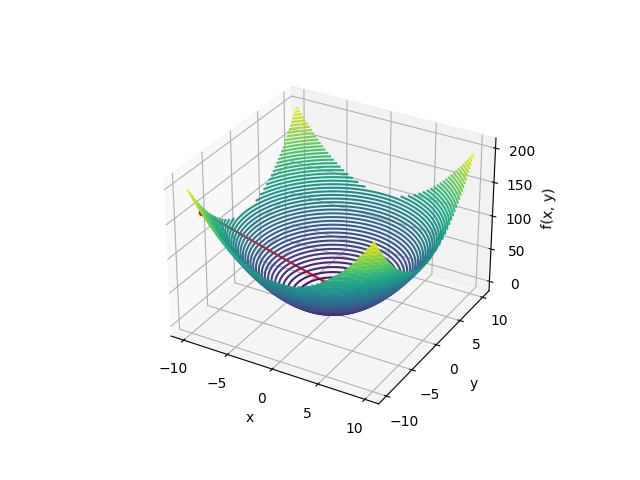

In [85]:
def gradient_descent_momentum(x, alpha, gamma, func_gradient, epsilon, solve_type='1', max_iter=100):
    x_new = np.zeros(x.shape)
    trajectory = np.array([x])
    m = np.zeros(x.shape)
    i = 0
    alpha_prev = 0
    x_prev = 0

    while i < max_iter:

        if solve_type == '1':
            m = gamma * m + (1 - gamma) * func_gradient(x)
            x_new = x_new - alpha * m

        elif solve_type == '2':
            alpha_modif = alpha * (1 - gamma)

            if i == 0:
                beta_modif = 0
            else:
                beta_modif = (alpha * gamma) / alpha_prev

            x_new = x - alpha_modif * func_gradient(x) + beta_modif * (x - x_prev)

        if np.linalg.norm(x - x_new) < epsilon:
            break

        i += 1
        alpha_prev = alpha
        x_prev = x
        x = x_new
        trajectory = np.append(trajectory, [x], axis=0)

    return x_new, trajectory, i

'''Starting variables'''
x_start = np.array([-9, -9])
epsilon = 0.0001
alpha = 0.8
gamma = 0.9
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

# Calling the function
x_min, trajectory, steps = gradient_descent_momentum(x_start, alpha, gamma, func_grad, epsilon, solve_type='1')

print('Minimum point:', x_min)

# Plot the function
plot_func(func, x, y, x_start, x_min, trajectory, type=1)

* Backpropagation
* Newton's Method
* Adam Optimization
* Simplex Method
* Mini-batch Gradient Descent
* Batch Gradient Descent

## Nesterov's Accelerated Gradient

https://www.mathworks.com/matlabcentral/answers/124593-how-to-calculate-lipschitz-constant
https://openreview.net/pdf?id=rJe4_xSFDB

Minimum point: [4.49969739 2.29999684]
Number of steps: 49


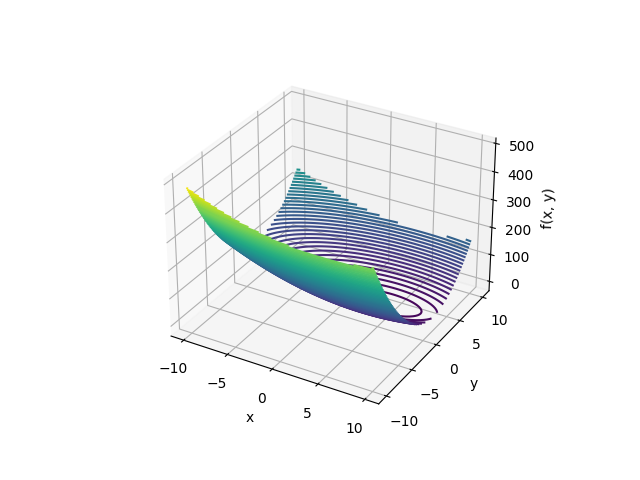

In [15]:
def dual_norm(x):
    return np.sqrt(np.sum(x**2))

def estimate_lipschitz(func_gradient, x, x_prev):
    return dual_norm(func_gradient(x) - func_gradient(x_prev)) / dual_norm(x - x_prev)
    

def nesterov_accelerated_gradient(x, func_gradient, epsilon, max_iter=100):
    x_new, x_prev = np.zeros(x.shape), np.zeros(x.shape)
    trajectory = np.array([x])
    i = 0
    lambda_prev = 0

    while i < max_iter:
        # L-lipschitz gradient
        L = estimate_lipschitz(func_gradient, x, x_prev)

        if L == 0:
            alpha = 1
        else:
            alpha = 1 / L

        lambda_new = (1 + np.sqrt(1 + 4 * lambda_prev**2)) / 2
        beta = (lambda_prev - 1) / lambda_new

        x_new = x - alpha * func_gradient(x + beta * (x - x_prev)) + beta * (x - x_prev)
        
        if np.linalg.norm(x - x_new) < epsilon:
            break

        i += 1
        lambda_prev = lambda_new
        x_prev = x
        x = x_new
        trajectory = np.append(trajectory, [x], axis=0)

    return x_new, trajectory, i

'''Starting variables'''
x_start = np.array([-9, -9])
epsilon = 0.0001
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

# Calling the function
x_min, trajectory, steps = nesterov_accelerated_gradient(x_start, func_grad, epsilon, max_iter=1000)

print('Minimum point:', x_min)
print('Number of steps:', steps)

# Plot the function
plot_func(func, x, y, x_start, x_min, trajectory, type=1)